# Hypothesis 1

In this notebook we will check if the the price p. sqft is higher in more densely populated places.
We check price per sqft lot as well as price per sqft of the living area to understand the data better.
The more densely populated places will be calculated as the average distance of all houses within the zipcode. 

In [1]:
import pandas as pd
import sys
import missingno as msno
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from haversine import haversine, Unit

from optional.data_processing import *


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)


df_all_housing_info = pd.read_csv('data/eda.csv')
df_all_housing_info.isna().sum()
#type(df_all_housing_info['date'][2])

#df_all_housing_info


id               0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
                ..
long             0
sqft_living15    0
sqft_lot15       0
date             0
price            0
Length: 21, dtype: int64

We don't need the following data: bedrooms, bathrooms, sqft_living15, sqft_lot15, date etc.
so we drop them to make calculations more efficient

In [2]:
df_all_housing_info = df_all_housing_info.drop(columns=['bedrooms','sqft_basement','sqft_above','bathrooms','condition','view','floors','grade','waterfront','yr_built', 'yr_renovated' ,'sqft_living15','sqft_lot15','date'])
df_all_housing_info

,id,sqft_living,sqft_lot,zipcode,lat,long,price
0,7129300520,1180.0,5650.0,98178,47.5112,-122.257,221900.0
1,6414100192,2570.0,7242.0,98125,47.7210,-122.319,538000.0
2,5631500400,770.0,10000.0,98028,47.7379,-122.233,180000.0
3,2487200875,1960.0,5000.0,98136,47.5208,-122.393,604000.0
4,1954400510,1680.0,8080.0,98074,47.6168,-122.045,510000.0
...,...,...,...,...,...,...,...
21592,263000018,1530.0,1131.0,98103,47.6993,-122.346,360000.0
21593,6600060120,2310.0,5813.0,98146,47.5107,-122.362,400000.0
21594,1523300141,1020.0,1350.0,98144,47.5944,-122.299,402101.0
21595,291310100,1600.0,2388.0,98027,47.5345,-122.069,400000.0


In [3]:
# Beispiel-DataFrame
# df = pd.DataFrame({'zipcode': [12345, 12345, 67890], 'lat': [52.52, 52.53, 48.85], 'long': [13.40, 13.41, 2.35]})

# Function to calculate the avg distance in a zipcode area
def calculate_avg_distance_per_zipcode(group):
    # All coordinates in a numpy-array
    coords = group[['lat', 'long']].to_numpy()
    

    # Create DF with each combination of distinct pairs of coordinates.
    pairs = pd.DataFrame(
        [(coords[i], coords[j]) for i in range(len(coords)) for j in range(i + 1, len(coords))],
        columns=['point1', 'point2']
    )
    
    # Calculate the distance of coordinates via haversine function and save them in a new column 
    pairs['distance'] = pairs.apply(
        lambda row: haversine(row['point1'], row['point2'], unit=Unit.FEET),
        axis=1
    )
    
    # Return the mean distance
    return pairs['distance'].mean()

#Create DF with zipcode and avg_distance
# df_avg_dist = df_all_housing_info.groupby(
#     'zipcode').apply(
#         calculate_avg_distance_per_zipcode).reset_index(
#         name='avg_distance')
# df_avg_dist.to_csv('data/avg_distance_per_zipcode.csv', index=False)
df_avg_dist =pd.read_csv('data/avg_distance_per_zipcode.csv')
df_avg_dist

,zipcode,avg_distance
0,98001,13972.115421
1,98002,9640.764253
2,98003,14218.417342
3,98004,9145.361957
4,98005,9882.870374
...,...,...
65,98177,12054.510660
66,98178,5603.937687
67,98188,5926.187752
68,98198,9939.782089


Now we'll create extra rows that contain the avg prices per lot/living. Then we safe the average through a groupby in the variable df_avg_prices.


In [4]:
#Create copy of main DF
df_extra_data = df_all_housing_info.copy()

#Add avg_price per lot as column
df_extra_data['price_p_lot'] = df_extra_data['price']/df_extra_data['sqft_lot']

#Add avg_price per living area as column
df_extra_data['price_p_living'] = df_extra_data['price']/df_extra_data['sqft_living']

#Take the mean of the avg's and the count per zipcode
df_avg_prices = df_extra_data.groupby(
    'zipcode').agg(
        avg_price_p_lot=('price_p_lot',lambda x: x.mean().round()),
        avg_price_p_living=('price_p_living',lambda x: x.mean().round()),
        count=('price', 'count'))

In [10]:
#merge the avg distances and avg prices per zipcode in a df
df_plot = df_avg_dist.merge(df_avg_prices,on='zipcode')
df_plot.sort_values('avg_distance')

,zipcode,avg_distance,avg_price_p_lot,avg_price_p_living,count
53,98119,3569.971692,287.0,432.0,184
54,98122,3647.428915,234.0,368.0,290
47,98109,3970.980842,281.0,434.0,109
24,98039,4169.465555,128.0,568.0,50
69,98199,4434.504986,173.0,377.0,317
...,...,...,...,...,...
8,98010,15459.939332,21.0,210.0,100
40,98092,17504.581787,35.0,156.0,351
15,98027,17996.606172,105.0,252.0,412
35,98070,20970.456320,15.0,278.0,117


In [13]:
df_all_housing_info[df_all_housing_info['zipcode']==98014]

,id,sqft_living,sqft_lot,zipcode,lat,long,price
350,7325600160,560.0,12120.0,98014,47.6750,-121.854,299000.0
465,8658300340,430.0,5050.0,98014,47.6499,-121.909,80000.0
569,4045500710,1160.0,15029.0,98014,47.6929,-121.870,405000.0
920,4046500320,1660.0,16275.0,98014,47.6903,-121.915,342000.0
1195,8658300260,1150.0,17585.0,98014,47.6503,-121.908,361000.0
...,...,...,...,...,...,...,...
20795,1825079046,1820.0,374616.0,98014,47.6539,-121.959,580000.0
21123,8658301060,1160.0,2500.0,98014,47.6489,-121.911,310000.0
21195,4045500950,1680.0,8000.0,98014,47.6923,-121.869,425000.0
21370,774101755,1790.0,66250.0,98014,47.7179,-121.403,320000.0


/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


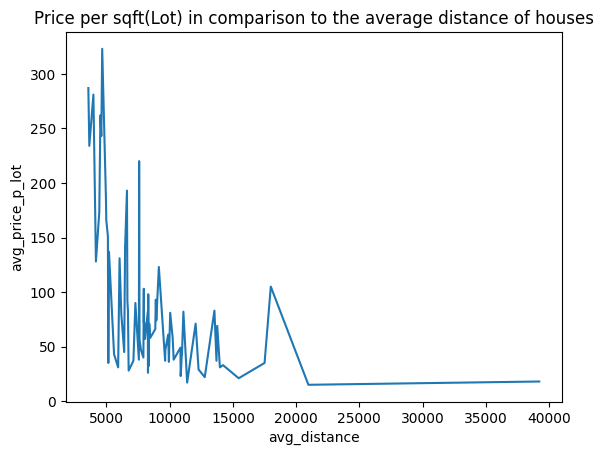

In [ ]:
#Plot avg price per lot by the avg distance
sns.lineplot(data=df_plot, x='avg_distance', y='avg_price_p_lot')
plt.rc('axes', titelsize=25)
plt.rc('axes',labelsize=22)
plt.rc('xtick', labelsize=18)
plt.rc('ytick',labelsize=16)
plt.title('Price per sqft(Lot) in comparison to the average distance of houses')



plt.savefig('data/distance_lot_price.png', dpi=300, bbox_inches='tight')


/tmp/ipykernel_91582/1574922529.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_binned = df_plot.groupby('distance_bin').agg({'avg_price_p_living': 'mean'}).reset_index()
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


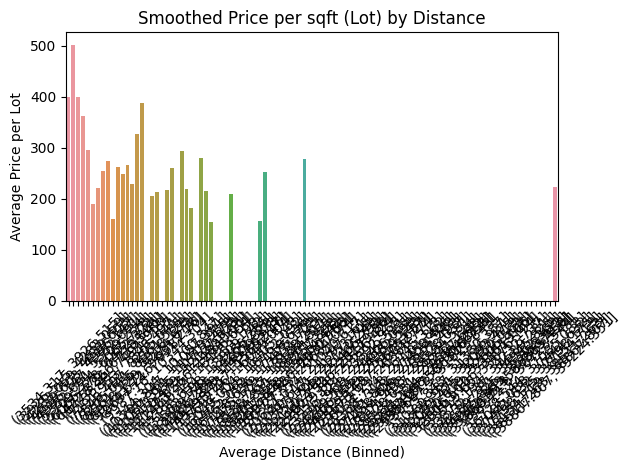

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Daten in Bins unterteilen
num_bins = 100  # Anzahl der Bins
df_plot['distance_bin'] = pd.cut(df_plot['avg_distance'], bins=num_bins)

# Durchschnittswerte pro Bin berechnen
df_binned = df_plot.groupby('distance_bin').agg({'avg_price_p_living': 'mean'}).reset_index()

# Barplot erstellen
sns.barplot(data=df_binned, x='distance_bin', y='avg_price_p_living')
plt.title('Smoothed Price per sqft (Lot) by Distance')
plt.xlabel('Average Distance (Binned)')
plt.ylabel('Average Price per Lot')
plt.xticks(rotation=45)  # Für bessere Lesbarkeit
plt.tight_layout()

# Plot speichern
#plt.savefig('data/distance_lot_price_smoothed.png', dpi=300, bbox_inches='tight')
plt.show()


/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


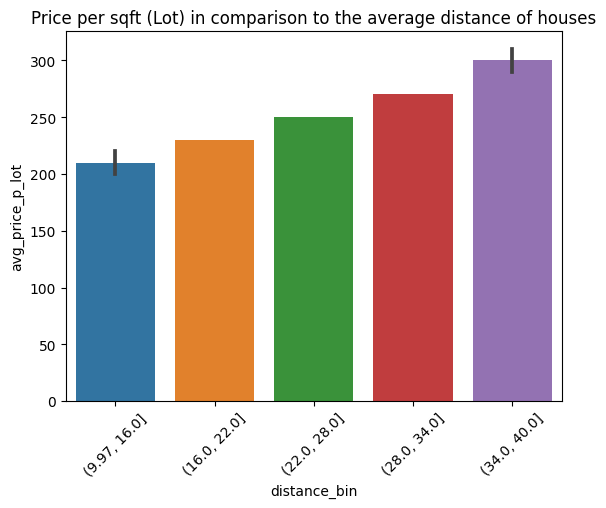

In [8]:

# Beispiel-DataFrame
df_plot = pd.DataFrame({
    'avg_distance': [10, 15, 20, 25, 30, 35, 40],
    'avg_price_p_lot': [200, 220, 230, 250, 270, 290, 310]
})

# Daten in Bins aufteilen
df_plot['distance_bin'] = pd.cut(df_plot['avg_distance'], bins=5)

# Barplot erstellen
sns.barplot(data=df_plot, x='distance_bin', y='avg_price_p_lot')
plt.title('Price per sqft (Lot) in comparison to the average distance of houses')
plt.xticks(rotation=45)  # Optional: bessere Lesbarkeit der Bins
plt.show()

/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/mahaeu/Exercises/Spiced_Projects/eda-housing-data/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Price per sqft(living area) in comparison to the average distance of houses')

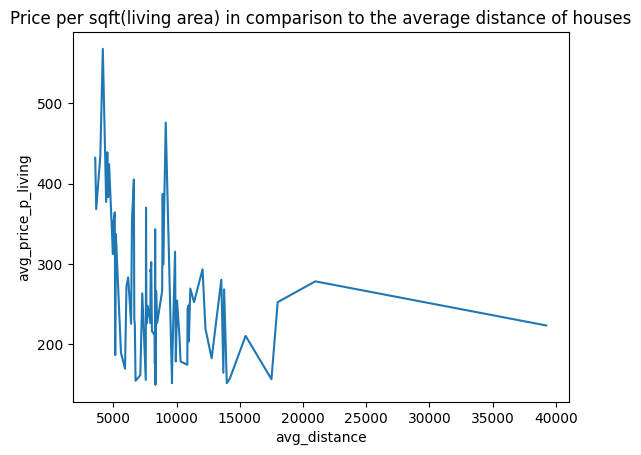

In [21]:
#Plot avg price per living area by the avg distance
sns.lineplot(data=df_plot, x='avg_distance', y='avg_price_p_living')
plt.title('Price per sqft(living area) in comparison to the average distance of houses')

#plt.savefig('data/distance_living_price.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes =plt.subplots(1,2)